<div class ="alert alert-block alert-warning">
    
- This notebook aims to apply AutoGluon-TimeSeries as covered by https://paperswithcode.com/paper/autogluon-timeseries-automl-for-probabilistic on the M5 dataset

- we aim to deploy it and run on the validation set having successfully implemented on 1 time-series in https://www.kaggle.com/code/yorkyong/m5-forecasting-autogluon-1series

# Import Libraries

In [1]:
# pip install autogluon thinc==8.2.5

In [2]:
import gc
import os
import psutil

import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations
import warnings  # To suppress warnings
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.timeseries.utils.forecast import get_forecast_horizon_index_ts_dataframe
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

import random  # For generating random numbers

# Function to set a fixed random seed for reproducibility
def seed_everything(seed):
    np.random.seed(seed)  # Set numpy random seed
    random.seed(seed)  # Set built-in random seed

seed_everything(seed=2024)  # Set the seed to 2024


# Load Dataset

In [3]:
calendar = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/calendar.csv")  # Load calendar dataset
print(f"len(calendar):{len(calendar)}")  # Print the number of rows in calendar
calendar

len(calendar):1969


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [4]:
sales_train_evaluation = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv")
print(f"len(sales_train_evaluation): {len(sales_train_evaluation)}")
sales_train_evaluation.head()

len(sales_train_evaluation): 30490


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [5]:
sell_prices = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sell_prices.csv")
print(f"len(sell_prices):{len(sell_prices)}")
sell_prices

len(sell_prices):6841121


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [6]:
# Enhanced memory optimization function with object datatype handling
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2  # Initial memory usage in MB
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:  # Downcast numerics
            c_min, c_max = df[col].min(), df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
        elif col_type == 'object':  # Handle object types
            if col == 'date':  # Convert date column to datetime
                df[col] = pd.to_datetime(df[col], format='%Y-%m-%d')
            else:
                df[col] = df[col].astype('category')  # Convert other object types to category
    end_mem = df.memory_usage().sum() / 1024**2  # Final memory usage in MB
    if verbose:
        print(f'Memory usage reduced to {end_mem:5.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

In [7]:
# Apply the optimized memory reduction function to each dataframe
calendar = reduce_mem_usage(calendar)
sell_prices = reduce_mem_usage(sell_prices)
sales_train_evaluation = reduce_mem_usage(sales_train_evaluation)

Memory usage reduced to  0.13 Mb (40.4% reduction)
Memory usage reduced to 45.76 Mb (78.1% reduction)
Memory usage reduced to 96.30 Mb (78.7% reduction)


# Convert Sales Data to Long format

In [8]:
# Specify day columns up to d_1941 for the extended dataset
d_cols_eval = [f"d_{i}" for i in range(1, 1942)]
sales_train_evaluation_long = sales_train_evaluation.melt(
    id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
    value_vars=d_cols_eval,
    var_name="d",
    value_name="sales"
)
print(f"len(sales_train_evaluation_long): {len(sales_train_evaluation_long)}")
sales_train_evaluation_long.head()

len(sales_train_evaluation_long): 59181090


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


# Label Endcode Calendar event

In [9]:
# Encode event-related features in the calendar dataframe
event_columns = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
le = LabelEncoder()
for col in event_columns:
    calendar[col] = le.fit_transform(calendar[col].astype(str))

# Merge with Calender data

In [10]:
sales_train_evaluation_long = sales_train_evaluation_long.merge(calendar, on="d", how="left")
sales_train_evaluation_long.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,30,4,4,2,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,30,4,4,2,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,30,4,4,2,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,30,4,4,2,0,0,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,30,4,4,2,0,0,0


# Merge with Price data

In [11]:
sales_train_evaluation_long = sales_train_evaluation_long.merge(
    sell_prices, 
    on=["store_id", "item_id", "wm_yr_wk"], 
    how="left"
)
sales_train_evaluation_long.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,30,4,4,2,0,0,0,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,30,4,4,2,0,0,0,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,30,4,4,2,0,0,0,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,30,4,4,2,0,0,0,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,30,4,4,2,0,0,0,NaN


# Define Train, Validation and Evaluation sets

In [12]:
train_set = sales_train_evaluation_long[sales_train_evaluation_long['d'].isin([f'd_{i}' for i in range(1500, 1914)])]
print("Train set sample:")
print(f"len(Train set): {len(train_set)}")
train_set.head()

Train set sample:
len(Train set): 12622860


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
45704510,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1500,0,2015-03-08,11506,...,3,2015,30,4,4,2,1,0,1,8.257812
45704511,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1500,0,2015-03-08,11506,...,3,2015,30,4,4,2,1,0,1,3.970703
45704512,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1500,0,2015-03-08,11506,...,3,2015,30,4,4,2,1,0,1,2.970703
45704513,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1500,10,2015-03-08,11506,...,3,2015,30,4,4,2,1,0,1,4.640625
45704514,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1500,2,2015-03-08,11506,...,3,2015,30,4,4,2,1,0,1,2.880859


In [13]:
# Filter the validation set for d_1914 to d_1941
validation_set = sales_train_evaluation_long[sales_train_evaluation_long['d'].isin([f'd_{i}' for i in range(1914, 1942)])]
print("Validation set sample:")
print(f"len(Validation set): {len(validation_set)}")
validation_set.head()


Validation set sample:
len(Validation set): 853720


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
58327370,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,0,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,8.382812
58327371,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,0,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,3.970703
58327372,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,0,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,2.970703
58327373,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,0,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,4.640625
58327374,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,1,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,2.880859


In [14]:
# Create a new DataFrame for the prediction period (d_1942 to d_1969)
forecast_days = [f'd_{i}' for i in range(1942, 1970)]
forecast_df = pd.DataFrame({'d': forecast_days})

# Generate one entry per product-store combination for each forecast day
prediction_set = sales_train_evaluation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()
prediction_set = prediction_set.merge(forecast_df, how='cross')

# Merge with calendar data to add date information for the forecast period
prediction_set = prediction_set.merge(calendar, on='d', how='left')

# Merge with sell_prices to add price data, aligning with the correct store, item, and week
prediction_set = prediction_set.merge(sell_prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')

print("Prediction set sample:")
print(f"len(Prediction set): {len(prediction_set)}")
prediction_set.head()


Prediction set sample:
len(Prediction set): 853720


,id,item_id,dept_id,cat_id,store_id,state_id,d,date,wm_yr_wk,weekday,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1942,2016-05-23,11617,Monday,...,5,2016,30,4,4,2,0,0,0,8.382812
1,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1943,2016-05-24,11617,Tuesday,...,5,2016,30,4,4,2,0,0,0,8.382812
2,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1944,2016-05-25,11617,Wednesday,...,5,2016,30,4,4,2,0,0,0,8.382812
3,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1945,2016-05-26,11617,Thursday,...,5,2016,30,4,4,2,0,0,0,8.382812
4,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1946,2016-05-27,11617,Friday,...,5,2016,30,4,4,2,0,0,0,8.382812


In [15]:
# Apply the optimized memory reduction function to each dataframe
train_set = reduce_mem_usage(train_set)
validation_set = reduce_mem_usage(validation_set)
prediction_set = reduce_mem_usage(prediction_set)

Memory usage reduced to 531.02 Mb (43.5% reduction)
Memory usage reduced to 36.34 Mb (44.0% reduction)
Memory usage reduced to 28.20 Mb (50.3% reduction)


In [16]:
train_set

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
45704510,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1500,0,2015-03-08,11506,...,3,2015,30,4,4,2,1,0,1,8.257812
45704511,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1500,0,2015-03-08,11506,...,3,2015,30,4,4,2,1,0,1,3.970703
45704512,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1500,0,2015-03-08,11506,...,3,2015,30,4,4,2,1,0,1,2.970703
45704513,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1500,10,2015-03-08,11506,...,3,2015,30,4,4,2,1,0,1,4.640625
45704514,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1500,2,2015-03-08,11506,...,3,2015,30,4,4,2,1,0,1,2.880859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58327365,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1913,1,2016-04-24,11613,...,4,2016,30,4,4,2,0,0,0,2.980469
58327366,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1913,0,2016-04-24,11613,...,4,2016,30,4,4,2,0,0,0,2.480469
58327367,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1913,0,2016-04-24,11613,...,4,2016,30,4,4,2,0,0,0,3.980469
58327368,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1913,3,2016-04-24,11613,...,4,2016,30,4,4,2,0,0,0,1.280273


In [17]:
validation_set

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
58327370,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,0,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,8.382812
58327371,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,0,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,3.970703
58327372,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,0,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,2.970703
58327373,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,0,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,4.640625
58327374,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,1,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,2.880859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59181085,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1941,1,2016-05-22,11617,...,5,2016,30,4,4,2,0,0,0,2.980469
59181086,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1941,0,2016-05-22,11617,...,5,2016,30,4,4,2,0,0,0,2.480469
59181087,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1941,2,2016-05-22,11617,...,5,2016,30,4,4,2,0,0,0,3.980469
59181088,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1941,0,2016-05-22,11617,...,5,2016,30,4,4,2,0,0,0,1.280273


In [18]:
prediction_set

,id,item_id,dept_id,cat_id,store_id,state_id,d,date,wm_yr_wk,weekday,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1942,2016-05-23,11617,Monday,...,5,2016,30,4,4,2,0,0,0,8.382812
1,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1943,2016-05-24,11617,Tuesday,...,5,2016,30,4,4,2,0,0,0,8.382812
2,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1944,2016-05-25,11617,Wednesday,...,5,2016,30,4,4,2,0,0,0,8.382812
3,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1945,2016-05-26,11617,Thursday,...,5,2016,30,4,4,2,0,0,0,8.382812
4,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1946,2016-05-27,11617,Friday,...,5,2016,30,4,4,2,0,0,0,8.382812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853715,FOODS_3_827_WI_3_evaluation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,d_1965,2016-06-15,11620,Wednesday,...,6,2016,30,4,4,2,0,1,1,1.000000
853716,FOODS_3_827_WI_3_evaluation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,d_1966,2016-06-16,11620,Thursday,...,6,2016,30,4,4,2,0,0,0,1.000000
853717,FOODS_3_827_WI_3_evaluation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,d_1967,2016-06-17,11620,Friday,...,6,2016,30,4,4,2,0,0,0,1.000000
853718,FOODS_3_827_WI_3_evaluation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,d_1968,2016-06-18,11621,Saturday,...,6,2016,30,4,4,2,0,0,0,1.000000


# Transform train_set into AutoGluon's TimeSeriesDataFrame

In [19]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12622860 entries, 45704510 to 58327369
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       category      
 2   dept_id       category      
 3   cat_id        category      
 4   store_id      category      
 5   state_id      category      
 6   d             category      
 7   sales         int16         
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       category      
 11  wday          int8          
 12  month         int8          
 13  year          int16         
 14  event_name_1  int8          
 15  event_type_1  int8          
 16  event_name_2  int8          
 17  event_type_2  int8          
 18  snap_CA       int8          
 19  snap_TX       int8          
 20  snap_WI       int8          
 21  sell_price    float16       
dtypes: category(8), datetime64[ns](1), float16(1), int16(3), int8(

In [20]:
# Step 1: Convert the 'date' column to datetime format
train_set['date'] = pd.to_datetime(train_set['date'])

# Step 2: Select only the relevant columns for AutoGluon, including target and covariates
covariate_columns = ['dept_id', 'store_id','sales', 'wday', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 
                     'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
train_set_for_autogluon = train_set[['id', 'date'] + covariate_columns].copy()

# Step 3: Sort the DataFrame by 'id' and 'date' to ensure correct order
train_set_for_autogluon = train_set_for_autogluon.sort_values(by=['id', 'date'])

# Step 4: Convert to AutoGluon TimeSeriesDataFrame format, specifying id_column and timestamp_column
train_set_for_autogluon = TimeSeriesDataFrame.from_data_frame(
    df=train_set_for_autogluon,
    id_column='id',
    timestamp_column='date'
)

In [21]:
train_set_for_autogluon = reduce_mem_usage(train_set_for_autogluon)

Memory usage reduced to 218.00 Mb (0.0% reduction)


In [22]:
train_set_for_autogluon

dept_id store_id  sales  wday  \
item_id                         timestamp                                       
FOODS_1_001_CA_1_evaluation     2015-03-08      FOODS_1     CA_1      1     2   
                                2015-03-09      FOODS_1     CA_1      0     3   
                                2015-03-10      FOODS_1     CA_1      1     4   
                                2015-03-11      FOODS_1     CA_1      0     5   
                                2015-03-12      FOODS_1     CA_1      1     6   
...                                                 ...      ...    ...   ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-04-20  HOUSEHOLD_2     WI_3      0     5   
                                2016-04-21  HOUSEHOLD_2     WI_3      0     6   
                                2016-04-22  HOUSEHOLD_2     WI_3      0     7   
                                2016-04-23  HOUSEHOLD_2     WI_3      0     1   
                                2016-04-24  HOUSEHOLD_2     WI_3      0     2   

                                            snap_CA  snap_TX  snap_WI  \
item_id                         timestamp                               
FOODS_1_001_CA_1_evaluation     2015-03-08        1        0        1   
                                2015-03-09        1        1        1   
                                2015-03-10        1        0        0   
                                2015-03-11        0        1        1   
                                2015-03-12        0        1        1   
...                                             ...      ...      ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-04-20        0        0        0   
                                2016-04-21        0        0        0   
                                2016-04-22        0        0        0   
                                2016-04-23        0        0        0   
                                2016-04-24        0        0        0   

                                            sell_price  event_name_1  \
item_id                         timestamp                              
FOODS_1_001_CA_1_evaluation     2015-03-08    2.240234            30   
                                2015-03-09    2.240234            30   
                                2015-03-10    2.240234            30   
                                2015-03-11    2.240234            30   
                                2015-03-12    2.240234            30   
...                                                ...           ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-04-20    5.941406            30   
                                2016-04-21    5.941406            30   
                                2016-04-22    5.941406            30   
                                2016-04-23    5.941406            30   
                                2016-04-24    5.941406            30   

                                            event_type_1  event_name_2  \
item_id                         timestamp                                
FOODS_1_001_CA_1_evaluation     2015-03-08             4             4   
                                2015-03-09             4             4   
                                2015-03-10             4             4   
                                2015-03-11             4             4   
                                2015-03-12             4             4   
...                                                  ...           ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-04-20             4             4   
                                2016-04-21             4             4   
                                2016-04-22             4             4   
                                2016-04-23             4             4   
                                2016-04-24             4             4   

                                            event_type_2  
item_id                         timestamp                 
FOODS_1_001_CA_1_evaluatio

In [23]:
# Check for missing values in each column of the DataFrame
missing_values = train_set_for_autogluon.isna().sum()

# Filter to show only columns with missing values
missing_values = missing_values[missing_values > 0]

# Display the missing values
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
sell_price    55736
dtype: int64


In [24]:
# Filter rows where 'sales' is negative
negative_sales_rows = train_set_for_autogluon[train_set_for_autogluon['sales'] < 0]

# Display the rows with negative 'sales' values
print(negative_sales_rows)


Empty TimeSeriesDataFrame
Columns: [dept_id, store_id, sales, wday, snap_CA, snap_TX, snap_WI, sell_price, event_name_1, event_type_1, event_name_2, event_type_2]
Index: []


# TimeSeriesPredictor

In [25]:
# Step 1: Initialize the TimeSeriesPredictor with a primary eval_metric
predictor = TimeSeriesPredictor(
    prediction_length=28,
    target="sales",
    known_covariates_names=['dept_id', 'store_id','wday', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'event_name_1','event_type_1','event_name_2', 'event_type_2'] ,
    eval_metric="RMSSE"  # Primary metric for training
)

No path specified. Models will be saved in: "AutogluonModels/ag-20241107_163422"


In [26]:
# Define custom lags
# custom_lags = list(range(28, 43))  # Lags from 28 to 42 days

# Define short-term, weekly and monthly lags
custom_lags = [1, 2, 3, 4, 5, 6, 7, 14, 21, 28, 56, 84] 


# Define LightGBM parameters
lgbm_params = {
                    'boosting_type': 'gbdt',
#                     'objective': 'tweedie',
                    'tweedie_variance_power': 1.1,
                    'metric': 'rmse',
                    'subsample': 0.5,
                    'subsample_freq': 1,
                    'learning_rate': 0.015,
                    'num_leaves': 2**11-1,
                    'min_data_in_leaf': 2**12-1,
                    'feature_fraction': 0.5,
                    'max_bin': 100,
                    'n_estimators': 3000,
                    'boost_from_average': False,
                    'verbose': -1,
                }

In [27]:
# Step 2: Fit the predictor with all models in the model zoo using default hyperparameters
predictor.fit(
    train_data=train_set_for_autogluon,
    hyperparameters={
        'DirectTabular': {
            'lags': custom_lags,
            'tabular_hyperparameters': {'GBM': lgbm_params},
        },
      
        'RecursiveTabular': {
            'lags': custom_lags,
            'tabular_hyperparameters': {'GBM': lgbm_params},
        },
        'Theta': {}

    }
)

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20241107_163422'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Jun 27 20:43:36 UTC 2024
CPU Count:          4
GPU Count:          0
Memory Avail:       18.88 GB / 31.36 GB (60.2%)
Disk Space Avail:   15.30 GB / 19.52 GB (78.4%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSSE,
 'hyperparameters': {'DirectTabular': {'lags': [1,
                                                2,
                                                3,
                                                4,
                                                5,
                                                6,
                                                7,
                                                14,
                                                21,
           

# Predict for Validation set 

In [28]:
# Step 1: Ensure 'date' is in datetime format
validation_set['date'] = pd.to_datetime(validation_set['date'])

# Step 2: Select only the relevant columns, ensuring 'sales' is included and filled with NaN
covariate_columns = ['dept_id', 'store_id','sales', 'wday', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 
                     'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
validation_set_for_autogluon = validation_set[['id', 'date'] + covariate_columns].copy()

# Step 3: Sort the DataFrame by 'id' and 'date' to ensure correct order
validation_set_for_autogluon = validation_set_for_autogluon.sort_values(by=['id', 'date'])

# Step 4: Convert to AutoGluon TimeSeriesDataFrame, specifying `id_column` and `timestamp_column`
validation_set_for_autogluon = TimeSeriesDataFrame(
    data=validation_set_for_autogluon,
    id_column='id',
    timestamp_column='date'
)

In [29]:
validation_set_for_autogluon

dept_id store_id  sales  wday  \
item_id                         timestamp                                       
FOODS_1_001_CA_1_evaluation     2016-04-25      FOODS_1     CA_1      2     3   
                                2016-04-26      FOODS_1     CA_1      0     4   
                                2016-04-27      FOODS_1     CA_1      0     5   
                                2016-04-28      FOODS_1     CA_1      0     6   
                                2016-04-29      FOODS_1     CA_1      0     7   
...                                                 ...      ...    ...   ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-05-18  HOUSEHOLD_2     WI_3      0     5   
                                2016-05-19  HOUSEHOLD_2     WI_3      0     6   
                                2016-05-20  HOUSEHOLD_2     WI_3      0     7   
                                2016-05-21  HOUSEHOLD_2     WI_3      0     1   
                                2016-05-22  HOUSEHOLD_2     WI_3      0     2   

                                            snap_CA  snap_TX  snap_WI  \
item_id                         timestamp                               
FOODS_1_001_CA_1_evaluation     2016-04-25        0        0        0   
                                2016-04-26        0        0        0   
                                2016-04-27        0        0        0   
                                2016-04-28        0        0        0   
                                2016-04-29        0        0        0   
...                                             ...      ...      ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-05-18        0        0        0   
                                2016-05-19        0        0        0   
                                2016-05-20        0        0        0   
                                2016-05-21        0        0        0   
                                2016-05-22        0        0        0   

                                            sell_price  event_name_1  \
item_id                         timestamp                              
FOODS_1_001_CA_1_evaluation     2016-04-25    2.240234            30   
                                2016-04-26    2.240234            30   
                                2016-04-27    2.240234            30   
                                2016-04-28    2.240234            30   
                                2016-04-29    2.240234            30   
...                                                ...           ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-05-18    5.941406            30   
                                2016-05-19    5.941406            30   
                                2016-05-20    5.941406            30   
                                2016-05-21    5.941406            30   
                                2016-05-22    5.941406            30   

                                            event_type_1  event_name_2  \
item_id                         timestamp                                
FOODS_1_001_CA_1_evaluation     2016-04-25             4             4   
                                2016-04-26             4             4   
                                2016-04-27             4             4   
                                2016-04-28             4             4   
                                2016-04-29             4             4   
...                                                  ...           ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-05-18             4             4   
                                2016-05-19             4             4   
                                2016-05-20             4             4   
                                2016-05-21             4             4   
                                2016-05-22             4             4   

                                            event_type_2  
item_id                         timestamp                 
FOODS_1_001_CA_1_evaluatio

In [30]:
# Step 5: Make predictions using the validation set as known covariates

%time
validation_preds = predictor.predict(train_set_for_autogluon, known_covariates=validation_set_for_autogluon)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [31]:
validation_preds

mean       0.1       0.2  \
item_id                         timestamp                                  
FOODS_1_001_CA_1_evaluation     2016-04-25  1.208144 -0.466697  0.082990   
                                2016-04-26  0.794792 -1.408060 -0.658220   
                                2016-04-27  0.993423 -1.642744 -0.709282   
                                2016-04-28  0.759393 -2.141740 -1.149163   
                                2016-04-29  0.914575 -2.123802 -1.096368   
...                                              ...       ...       ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-05-18  0.096941 -0.902069 -0.559434   
                                2016-05-19  0.092622 -0.932474 -0.574169   
                                2016-05-20  0.089782 -0.978167 -0.608609   
                                2016-05-21  0.101853 -0.920759 -0.564456   
                                2016-05-22  0.086882 -0.992203 -0.631014   

                                                 0.3       0.4       0.5  \
item_id                         timestamp                                  
FOODS_1_001_CA_1_evaluation     2016-04-25  0.481858  0.880369  1.231827   
                                2016-04-26 -0.120589  0.319431  0.716137   
                                2016-04-27 -0.069104  0.482207  0.972458   
                                2016-04-28 -0.461086  0.135710  0.681665   
                                2016-04-29 -0.327373  0.307490  0.894998   
...                                              ...       ...       ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-05-18 -0.316371 -0.105523  0.086637   
                                2016-05-19 -0.304420 -0.064833  0.126730   
                                2016-05-20 -0.359664 -0.143040  0.066882   
                                2016-05-21 -0.320931 -0.112291  0.096454   
                                2016-05-22 -0.356381 -0.140717  0.083365   

                                                 0.6       0.7       0.8  \
item_id                         timestamp                                  
FOODS_1_001_CA_1_evaluation     2016-04-25  1.592560  1.954156  2.370265   
                                2016-04-26  1.163248  1.618599  2.145623   
                                2016-04-27  1.443189  1.988660  2.611836   
                                2016-04-28  1.261298  1.850413  2.522576   
                                2016-04-29  1.481122  2.145178  2.953763   
...                                              ...       ...       ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-05-18  0.282945  0.498418  0.751266   
                                2016-05-19  0.310821  0.507011  0.761859   
                                2016-05-20  0.282617  0.497978  0.753168   
                                2016-05-21  0.308545  0.518727  0.781736   
                                2016-05-22  0.284524  0.511447  0.761803   

                                                 0.9  
item_id                         timestamp             
FOODS_1_001_CA_1_evaluation     2016-04-25  2.997741  
                                2016-04-26  2.857738  
                                2016-04-27  3.483045  
                                2016-04-28  3.513010  
                                2016-04-29  4.036715  
...                                              ...  
HOUSEHOLD_2_516_WI_3_evaluation 2016-05-18  1.084485  
                                2016-05-19  1.103947  
                                2016-05-20  1.123440  
                                2016-05-21  1.127444  
                                2016-05-22  1.133590  

[853720 rows x 10 columns]

In [32]:
validation_preds.info()

<class 'autogluon.timeseries.dataset.ts_dataframe.TimeSeriesDataFrame'>
MultiIndex: 853720 entries, ('FOODS_1_001_CA_1_evaluation', Timestamp('2016-04-25 00:00:00')) to ('HOUSEHOLD_2_516_WI_3_evaluation', Timestamp('2016-05-22 00:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   mean    853720 non-null  float64
 1   0.1     853720 non-null  float64
 2   0.2     853720 non-null  float64
 3   0.3     853720 non-null  float64
 4   0.4     853720 non-null  float64
 5   0.5     853720 non-null  float64
 6   0.6     853720 non-null  float64
 7   0.7     853720 non-null  float64
 8   0.8     853720 non-null  float64
 9   0.9     853720 non-null  float64
dtypes: float64(10)
memory usage: 68.9 MB


In [33]:
target_item_id = 'FOODS_3_586_TX_1_evaluation'

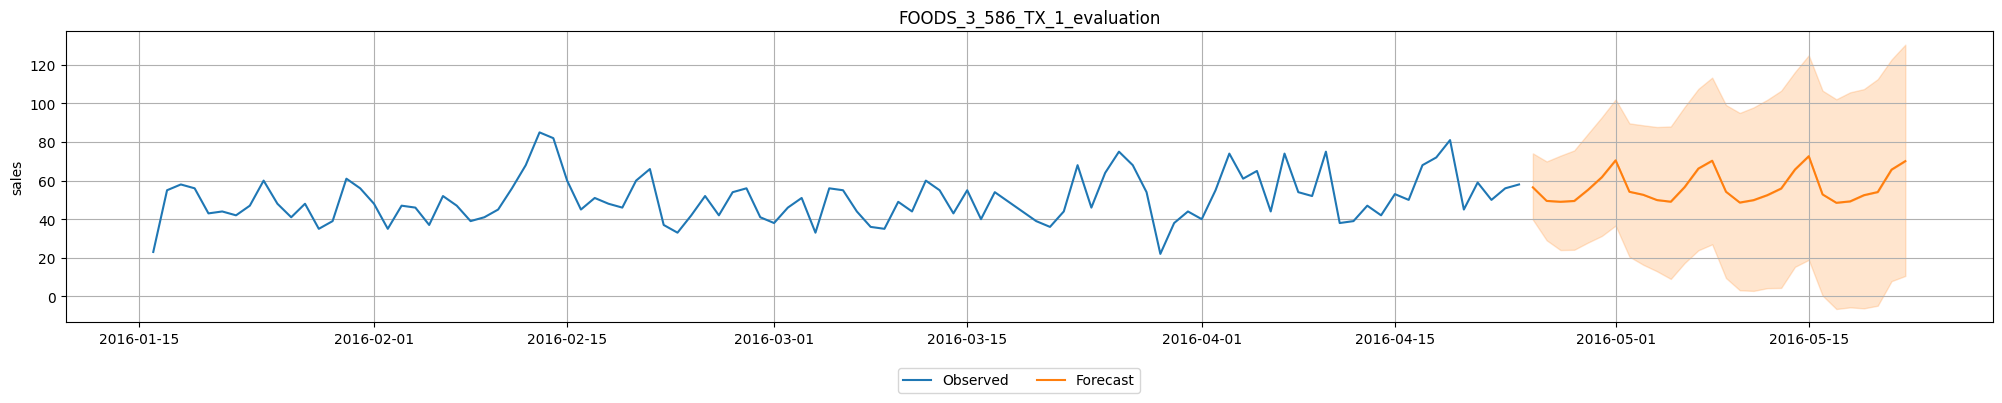

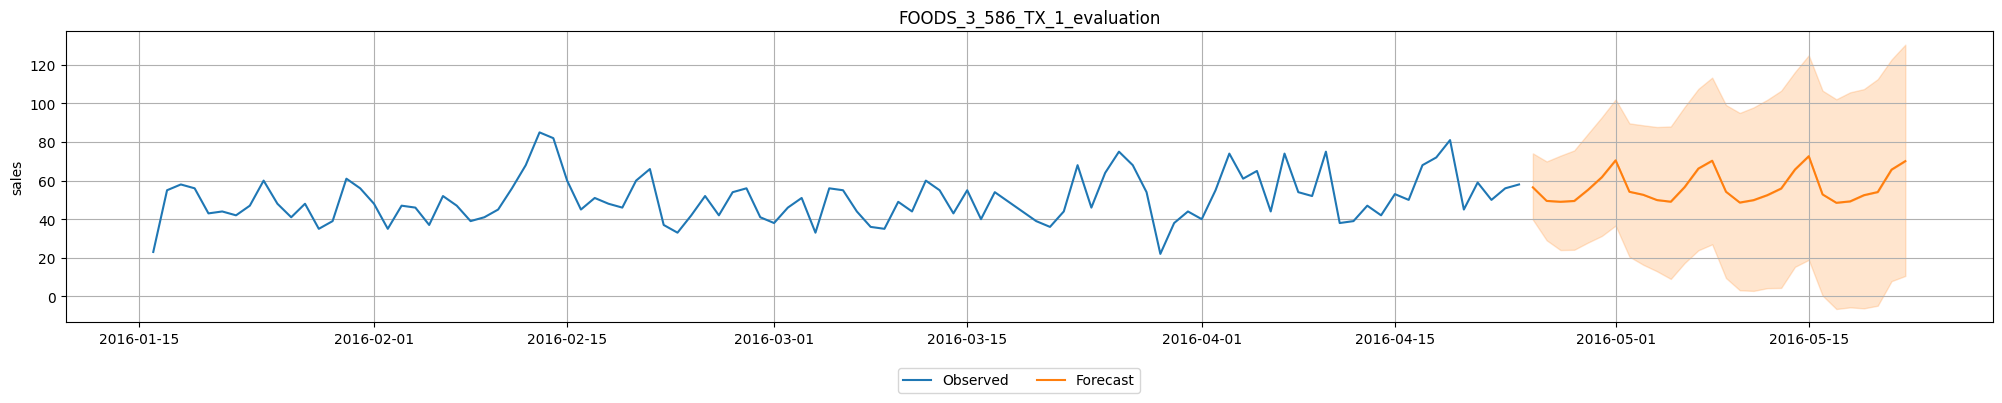

In [34]:
predictor.plot(
    data=train_set_for_autogluon,
    predictions=validation_preds,
    item_ids=[target_item_id],
    max_history_length=100  # Adjust as needed to display more or fewer historical points
)

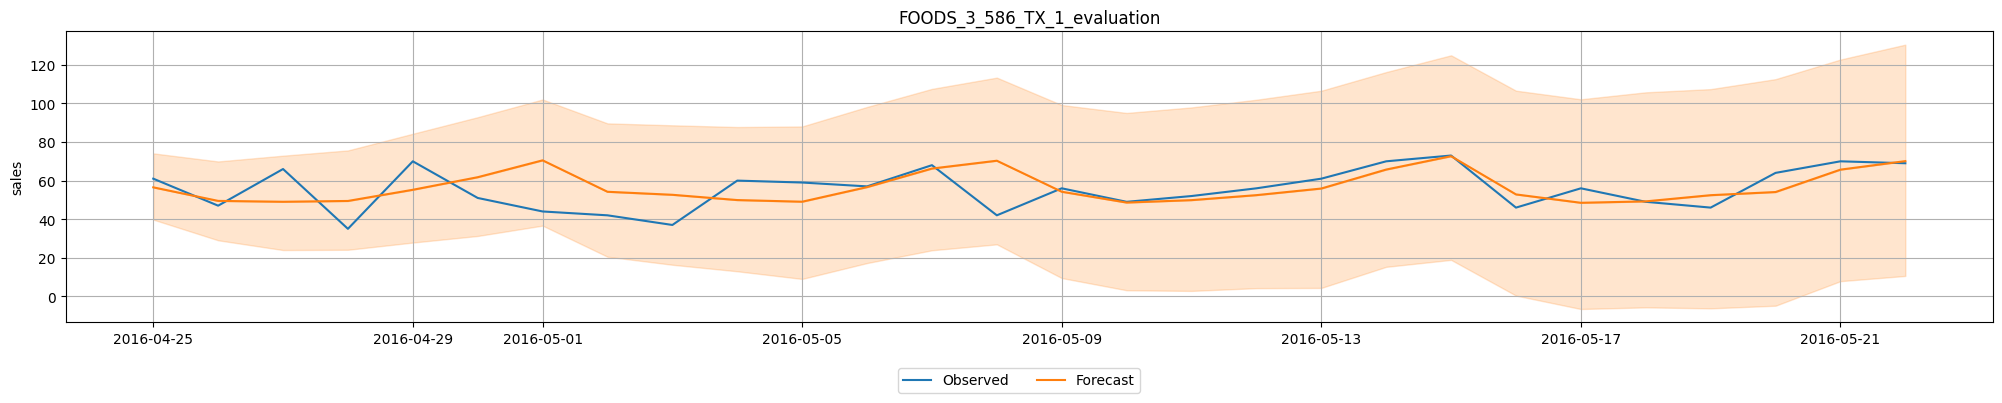

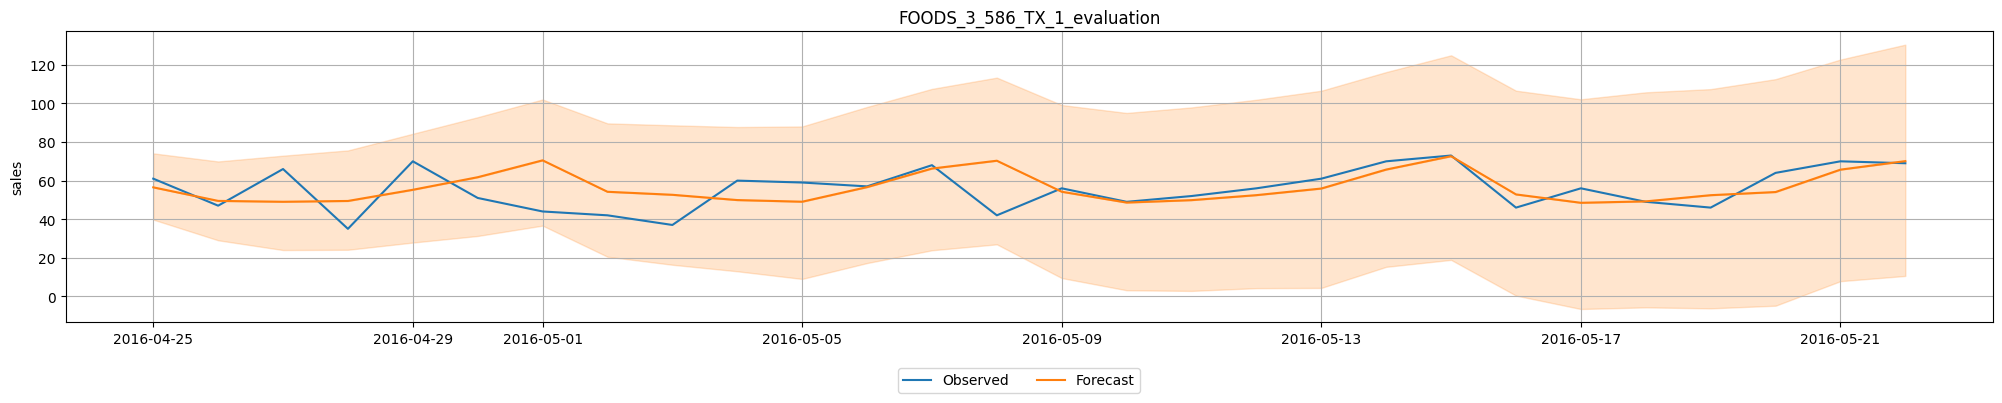

In [35]:
predictor.plot(
    data=validation_set_for_autogluon,
    predictions=validation_preds,
    item_ids=[target_item_id],
    max_history_length=28 
)

In [36]:
# Step 1: Extract the mean predictions
mean_predictions = validation_preds['mean']

# Step 2: Reshape the data
mean_predictions = mean_predictions.reset_index()
mean_predictions['forecast_day'] = mean_predictions.groupby('item_id').cumcount() + 1
validation_df = mean_predictions.pivot(index='item_id', columns='forecast_day', values='mean').reset_index()

# Step 3: Rename columns
validation_df.columns = ['id'] + [f'F{i}' for i in range(1, 29)]

# Step 4: Modify 'id' for submission
validation_df['id'] = validation_df['id'].str.replace('evaluation', 'validation')


In [37]:
validation_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,1.208144,0.794792,0.993423,0.759393,0.914575,0.937318,0.991085,1.251470,0.922864,...,0.834137,1.032886,0.927631,1.291718,0.780730,0.990629,0.927628,0.915911,1.092034,1.030755
1,FOODS_1_001_CA_2_validation,1.211503,1.264626,1.482904,1.383657,1.484275,1.478399,2.368822,1.149505,1.273678,...,1.317866,1.430702,2.246937,1.147829,1.209843,1.561207,1.436812,1.466779,1.523505,2.174977
2,FOODS_1_001_CA_3_validation,0.897521,0.928487,1.112853,1.217814,1.093230,1.384574,1.551344,1.120933,1.268325,...,1.024421,1.202436,1.270089,1.278202,1.321752,1.263948,1.083731,1.026127,1.011157,1.168352
3,FOODS_1_001_CA_4_validation,0.454761,0.450689,0.422654,0.448929,0.464420,0.506736,0.433209,0.419715,0.369441,...,0.410533,0.413382,0.452593,0.418535,0.389947,0.365052,0.389354,0.430845,0.430768,0.468261
4,FOODS_1_001_TX_1_validation,0.241317,0.261194,0.268233,0.307033,0.302926,0.335836,0.413454,0.357466,0.353436,...,0.412975,0.440006,0.485039,0.310965,0.261226,0.369824,0.450843,0.425695,0.520610,0.554776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.351411,0.323890,0.309455,0.347565,0.421402,0.411872,0.434743,0.389559,0.358366,...,0.381068,0.447651,0.465982,0.420635,0.419623,0.339944,0.312631,0.312936,0.388028,0.439556
30486,HOUSEHOLD_2_516_TX_3_validation,0.115747,0.118686,0.121799,0.117497,0.143854,0.147035,0.159369,0.157044,0.157787,...,0.208845,0.201263,0.192658,0.193997,0.184745,0.184428,0.179284,0.169281,0.190562,0.211306
30487,HOUSEHOLD_2_516_WI_1_validation,0.061109,0.057236,0.059335,0.059433,0.084968,0.082844,0.082452,0.073898,0.071944,...,0.079139,0.086999,0.092115,0.071467,0.063634,0.079277,0.079602,0.086367,0.091397,0.099687
30488,HOUSEHOLD_2_516_WI_2_validation,0.078038,0.089265,0.085722,0.062973,0.095591,0.092328,0.100934,0.097965,0.098595,...,0.104277,0.109585,0.105120,0.092017,0.091243,0.092418,0.086237,0.088657,0.099727,0.096876


# Predict for Prediction set

In [38]:
# Step 1: Ensure 'date' is in datetime format
prediction_set['date'] = pd.to_datetime(prediction_set['date'])

# Step 2: Select only the relevant columns, ensuring 'sales' is included and filled with NaN
covariate_columns = ['dept_id', 'store_id', 'wday', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 
                     'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
prediction_set_for_autogluon = prediction_set[['id', 'date'] + covariate_columns].copy()

# Step 4: Convert to AutoGluon TimeSeriesDataFrame, specifying `id_column` and `timestamp_column`
prediction_set_for_autogluon = TimeSeriesDataFrame(
    data=prediction_set_for_autogluon,
    id_column='id',
    timestamp_column='date'
)

In [39]:
# Concatenate the training and validation sets
combined_df = pd.concat([train_set_for_autogluon, validation_set_for_autogluon])

# Convert the concatenated DataFrame back to a TimeSeriesDataFrame
combined_tsdf = TimeSeriesDataFrame(combined_df)

In [40]:
%time
# Step 4: Make predictions using the prediction set as known covariates
prediction_preds = predictor.predict(combined_tsdf, known_covariates=prediction_set_for_autogluon)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


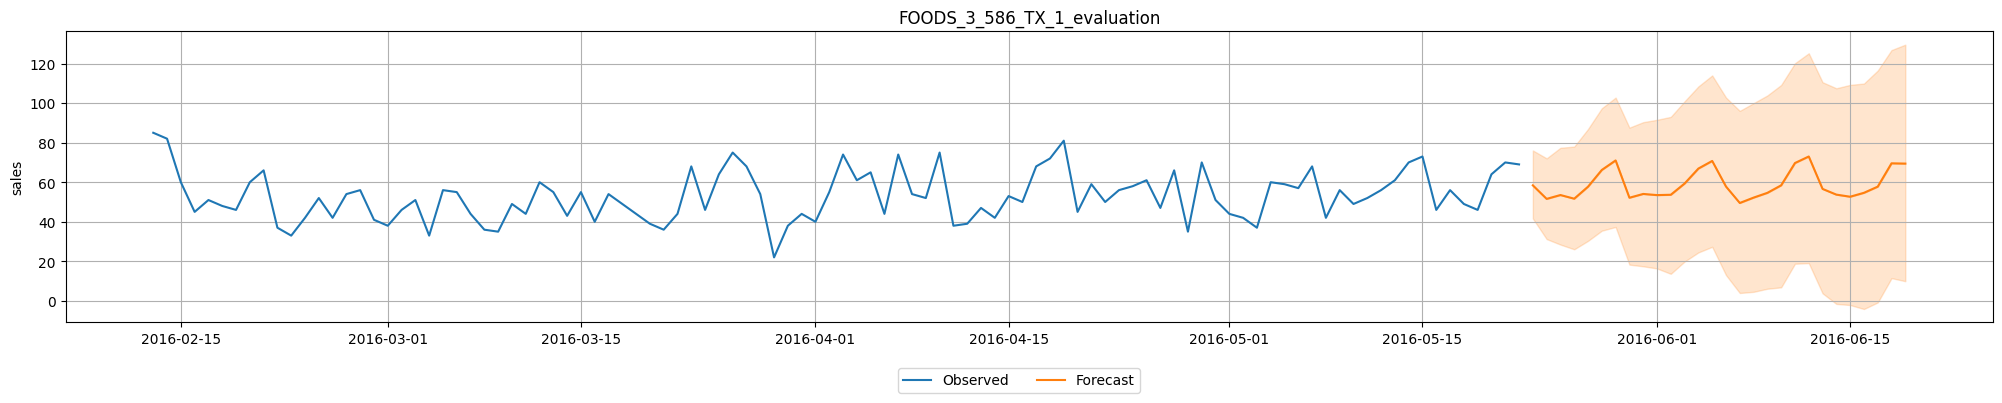

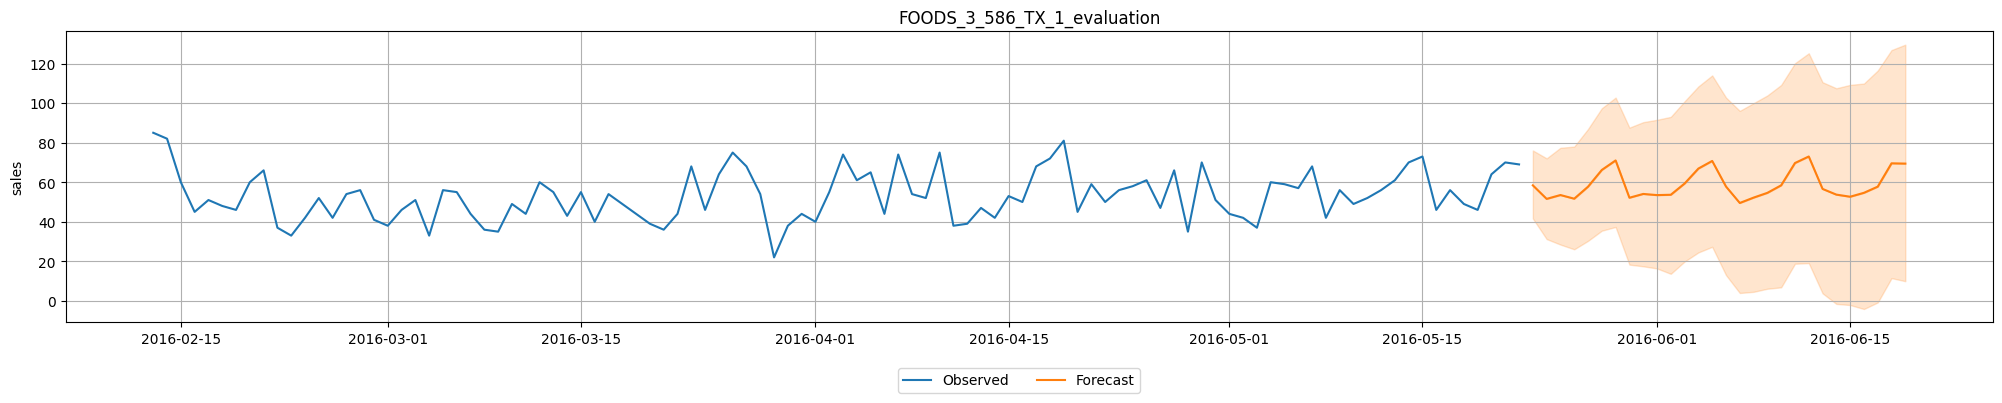

In [41]:
predictor.plot(
    data=combined_tsdf,
    predictions=prediction_preds,
    item_ids=[target_item_id],
    max_history_length=100  # Adjust as needed to display more or fewer historical points
)

In [42]:
# Step 1: Extract the mean predictions
mean_predictions1 = prediction_preds['mean']

# Step 2: Reshape the data
mean_predictions1 = mean_predictions1.reset_index()
mean_predictions1['forecast_day'] = mean_predictions1.groupby('item_id').cumcount() + 1
prediction_df = mean_predictions1.pivot(index='item_id', columns='forecast_day', values='mean').reset_index()

# Step 3: Rename columns
prediction_df.columns = ['id'] + [f'F{i}' for i in range(1, 29)]

In [43]:
prediction_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.485309,0.757327,0.524690,0.663795,0.737555,0.821061,0.840456,0.623622,0.845223,...,0.709055,0.742335,0.712257,0.585277,0.537314,0.490595,0.708759,0.631092,0.712330,0.785372
1,FOODS_1_001_CA_2_evaluation,0.915677,0.840137,0.683602,0.697902,1.031733,0.862092,1.058779,0.808791,0.920360,...,0.955557,1.162683,0.823888,0.875557,0.873616,0.851113,0.865530,1.129340,1.160525,0.936855
2,FOODS_1_001_CA_3_evaluation,1.036005,1.051402,1.113297,1.298093,1.435520,1.509162,1.328995,1.146566,1.160394,...,1.244521,1.374100,1.159015,1.087377,1.298630,1.055040,1.140095,1.322241,1.352808,1.480032
3,FOODS_1_001_CA_4_evaluation,0.302537,0.307613,0.336985,0.298011,0.268306,0.294917,0.331549,0.250236,0.315748,...,0.240923,0.253366,0.270694,0.216156,0.291367,0.267717,0.321337,0.290045,0.255131,0.263049
4,FOODS_1_001_TX_1_evaluation,1.153086,1.194383,1.052284,1.148613,1.023100,1.128288,1.192305,0.990542,1.223742,...,1.045022,1.014609,1.196836,0.982932,1.254883,0.965777,1.164750,1.111590,1.116642,1.363465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_evaluation,0.282542,0.280630,0.314804,0.330492,0.373780,0.353686,0.415347,0.321855,0.328445,...,0.288480,0.362017,0.388482,0.320876,0.367181,0.311943,0.291903,0.312571,0.401238,0.378075
30486,HOUSEHOLD_2_516_TX_3_evaluation,0.404044,0.396872,0.408570,0.391674,0.442124,0.455947,0.408229,0.384300,0.377378,...,0.427761,0.472803,0.469511,0.415589,0.417407,0.399619,0.407348,0.434641,0.485515,0.473627
30487,HOUSEHOLD_2_516_WI_1_evaluation,0.114251,0.132604,0.138463,0.125869,0.168204,0.152135,0.157422,0.140120,0.140732,...,0.161683,0.150221,0.158809,0.142609,0.138145,0.145369,0.145084,0.165214,0.171826,0.157228
30488,HOUSEHOLD_2_516_WI_2_evaluation,0.107224,0.094695,0.104188,0.109391,0.115219,0.114424,0.114459,0.121442,0.115025,...,0.123497,0.127907,0.114119,0.135707,0.121870,0.118579,0.104894,0.124044,0.122856,0.118931


# For Submission

In [44]:
# Combine validation and evaluation for submission
submit = pd.concat([validation_df, prediction_df]).reset_index(drop=True)
submit.to_csv('submission.csv', index=False)

In [45]:
submit.head(10)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,1.208144,0.794792,0.993423,0.759393,0.914575,0.937318,0.991085,1.251470,0.922864,...,0.834137,1.032886,0.927631,1.291718,0.780730,0.990629,0.927628,0.915911,1.092034,1.030755
1,FOODS_1_001_CA_2_validation,1.211503,1.264626,1.482904,1.383657,1.484275,1.478399,2.368822,1.149505,1.273678,...,1.317866,1.430702,2.246937,1.147829,1.209843,1.561207,1.436812,1.466779,1.523505,2.174977
2,FOODS_1_001_CA_3_validation,0.897521,0.928487,1.112853,1.217814,1.093230,1.384574,1.551344,1.120933,1.268325,...,1.024421,1.202436,1.270089,1.278202,1.321752,1.263948,1.083731,1.026127,1.011157,1.168352
3,FOODS_1_001_CA_4_validation,0.454761,0.450689,0.422654,0.448929,0.464420,0.506736,0.433209,0.419715,0.369441,...,0.410533,0.413382,0.452593,0.418535,0.389947,0.365052,0.389354,0.430845,0.430768,0.468261
4,FOODS_1_001_TX_1_validation,0.241317,0.261194,0.268233,0.307033,0.302926,0.335836,0.413454,0.357466,0.353436,...,0.412975,0.440006,0.485039,0.310965,0.261226,0.369824,0.450843,0.425695,0.520610,0.554776
5,FOODS_1_001_TX_2_validation,0.390121,0.475671,0.548984,0.552937,0.594182,0.505258,0.544200,0.546110,0.438435,...,0.647045,0.652924,0.594497,0.542028,0.612419,0.471249,0.517093,0.475591,0.593187,0.495674
6,FOODS_1_001_TX_3_validation,0.485552,0.413339,0.481148,0.557008,0.463795,0.471600,0.592636,0.487382,0.402284,...,0.464071,0.444179,0.579849,0.444950,0.458707,0.475737,0.530904,0.486662,0.474629,0.486664
7,FOODS_1_001_WI_1_validation,0.802929,0.807712,0.750588,0.771188,0.806429,1.455502,0.859828,0.726383,0.732175,...,0.799149,1.561193,0.801177,0.694488,0.802606,0.763029,0.768394,0.711149,1.583612,0.879018
8,FOODS_1_001_WI_2_validation,0.369377,0.346192,0.482059,0.300419,0.294840,0.304038,0.337056,0.364364,0.357560,...,0.337930,0.308755,0.333677,0.388456,0.382826,0.514941,0.374105,0.343055,0.343627,0.351620
9,FOODS_1_001_WI_3_validation,0.372509,0.338932,0.372808,0.338902,0.370432,0.664039,0.354218,0.371683,0.358840,...,0.362236,0.648449,0.371162,0.377106,0.361345,0.334755,0.354316,0.354020,0.650833,0.366145


In [46]:
submit.tail(10)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
60970,HOUSEHOLD_2_516_CA_1_evaluation,0.175437,0.206984,0.194366,0.215794,0.219868,0.252380,0.241239,0.217711,0.203705,...,0.240111,0.273112,0.267853,0.228285,0.229649,0.182046,0.228443,0.242699,0.313636,0.262618
60971,HOUSEHOLD_2_516_CA_2_evaluation,0.452661,0.470524,0.466496,0.420237,0.425905,0.566091,0.454792,0.447203,0.472692,...,0.427624,0.597256,0.459918,0.451968,0.444623,0.443613,0.437218,0.447185,0.601267,0.482912
60972,HOUSEHOLD_2_516_CA_3_evaluation,0.181015,0.187564,0.156964,0.189801,0.178907,0.197601,0.156121,0.192781,0.235167,...,0.164272,0.207817,0.150942,0.206056,0.232784,0.164884,0.175164,0.179074,0.208983,0.136346
60973,HOUSEHOLD_2_516_CA_4_evaluation,0.114998,0.109271,0.105683,0.120504,0.133454,0.143698,0.153071,0.144144,0.151826,...,0.133139,0.149983,0.148755,0.144113,0.160623,0.142646,0.152815,0.162263,0.168241,0.157060
60974,HOUSEHOLD_2_516_TX_1_evaluation,0.043072,0.046486,0.047384,0.050536,0.059857,0.057475,0.064609,0.054607,0.060250,...,0.060814,0.073146,0.078427,0.072650,0.067625,0.060793,0.062590,0.063183,0.078321,0.075986
60975,HOUSEHOLD_2_516_TX_2_evaluation,0.282542,0.280630,0.314804,0.330492,0.373780,0.353686,0.415347,0.321855,0.328445,...,0.288480,0.362017,0.388482,0.320876,0.367181,0.311943,0.291903,0.312571,0.401238,0.378075
60976,HOUSEHOLD_2_516_TX_3_evaluation,0.404044,0.396872,0.408570,0.391674,0.442124,0.455947,0.408229,0.384300,0.377378,...,0.427761,0.472803,0.469511,0.415589,0.417407,0.399619,0.407348,0.434641,0.485515,0.473627
60977,HOUSEHOLD_2_516_WI_1_evaluation,0.114251,0.132604,0.138463,0.125869,0.168204,0.152135,0.157422,0.140120,0.140732,...,0.161683,0.150221,0.158809,0.142609,0.138145,0.145369,0.145084,0.165214,0.171826,0.157228
60978,HOUSEHOLD_2_516_WI_2_evaluation,0.107224,0.094695,0.104188,0.109391,0.115219,0.114424,0.114459,0.121442,0.115025,...,0.123497,0.127907,0.114119,0.135707,0.121870,0.118579,0.104894,0.124044,0.122856,0.118931
60979,HOUSEHOLD_2_516_WI_3_evaluation,0.087590,0.090225,0.087934,0.087566,0.083430,0.115947,0.104235,0.093849,0.101271,...,0.111147,0.115220,0.110278,0.106910,0.109710,0.111939,0.109876,0.111938,0.127210,0.114817
